# Notebook for making confusion matrices

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os, os.path
import sys
#sys.path.append('..\phase1_analysis')
#from phase1_data_analysis import GetUncertaintyLabels

## Read in data

In [87]:
ntn_subjects = pd.read_csv('../../data/ntn_result_aggregated.csv')

In [88]:
def GetUncertaintyLabels(matrix_ntn_subjects):
    '''Helper function for generating confusion matrix labels'''
    labels = []
    nrows, ncols = matrix_ntn_subjects.shape
    for i in range(0,nrows):
        col_sum = matrix_ntn_subjects.iloc[:,i].sum()
        for k in range(0,ncols):
            val = matrix_ntn_subjects.iloc[k,i]
            n_val = (val/col_sum.astype(float))*100
            val_percent_round = "%.1f" % n_val
            lab_n = '%.1f%%'%n_val
            lab_v = '%d/%d'%(val,col_sum)
            lab='%.1f%%\n%d/%d' % (n_val, val, col_sum)
            labelc= str(lab_n)+"\n"+str(lab_v)
            label = f"{str(lab_n)} {str(lab_v)}"
            labels.append(str(lab))
    labels_array = np.asarray(labels)
    labels_val = labels_array.reshape(5,5)
    labels_new = labels_val.T
    return labels_new


In [89]:
types = ['Skimming','Cascade','Through-Going\nTrack','Starting\nTrack','Stopping\nTrack'] #labels

## Original (no cuts) user vs. MC 

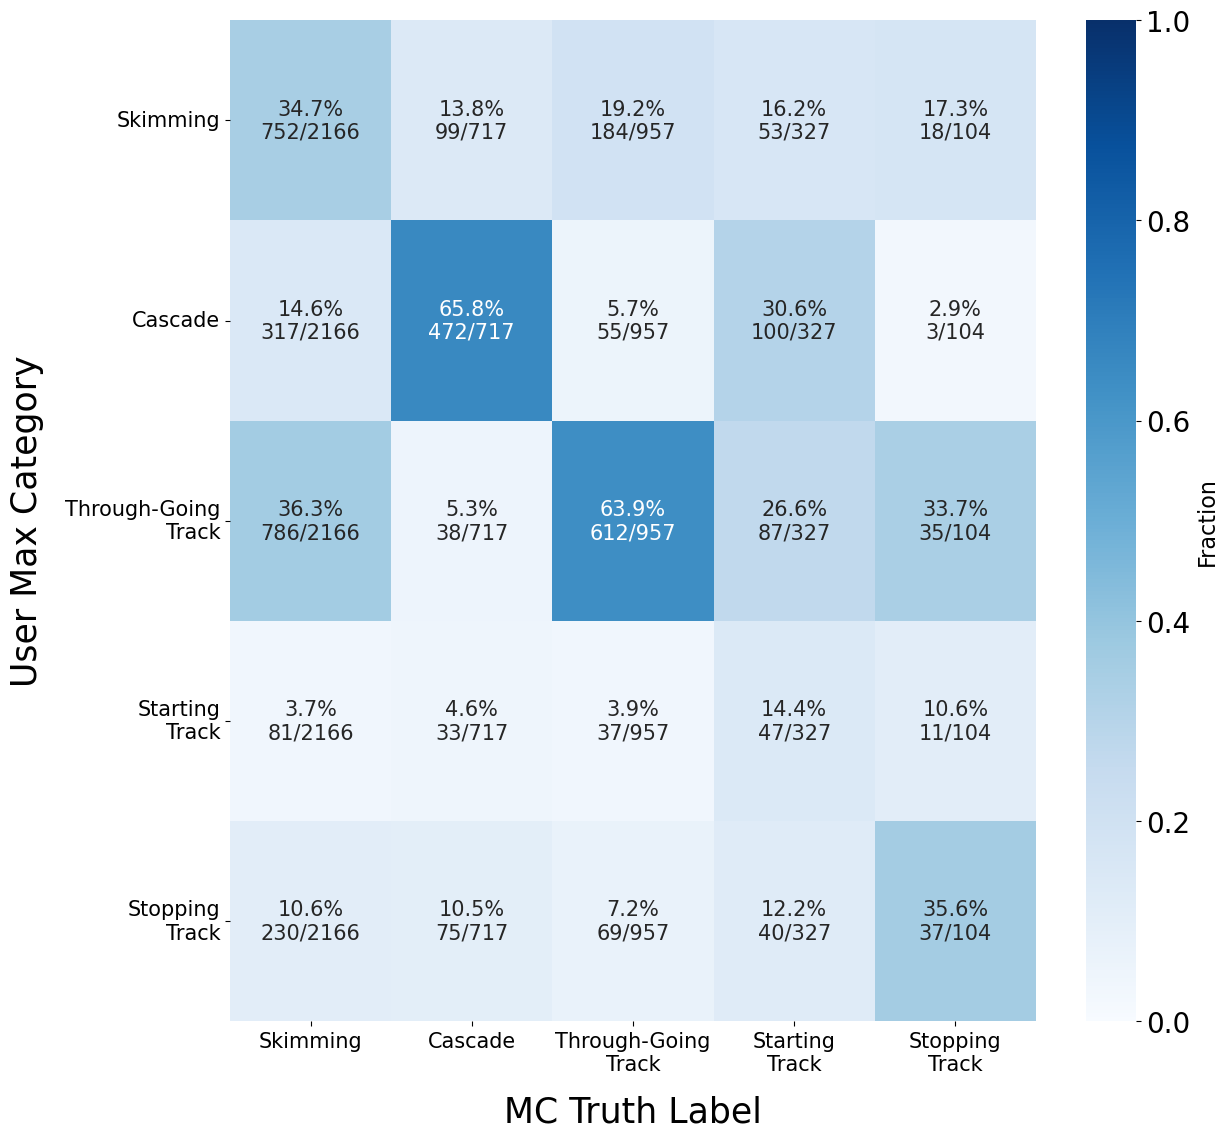

In [90]:
conf_norm = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['truth_classification'], rownames=['User Max Category'], colnames=['MC Truth Label'], margins=False,normalize='columns')
conf = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['truth_classification'], rownames=['User Max Category'], colnames=['MC Truth Label'], margins=False)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(conf_norm, annot=GetUncertaintyLabels(conf), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
plt.ylabel('User Max Category',fontsize=25,labelpad=15)
plt.xlabel('MC Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15")
plt.show()

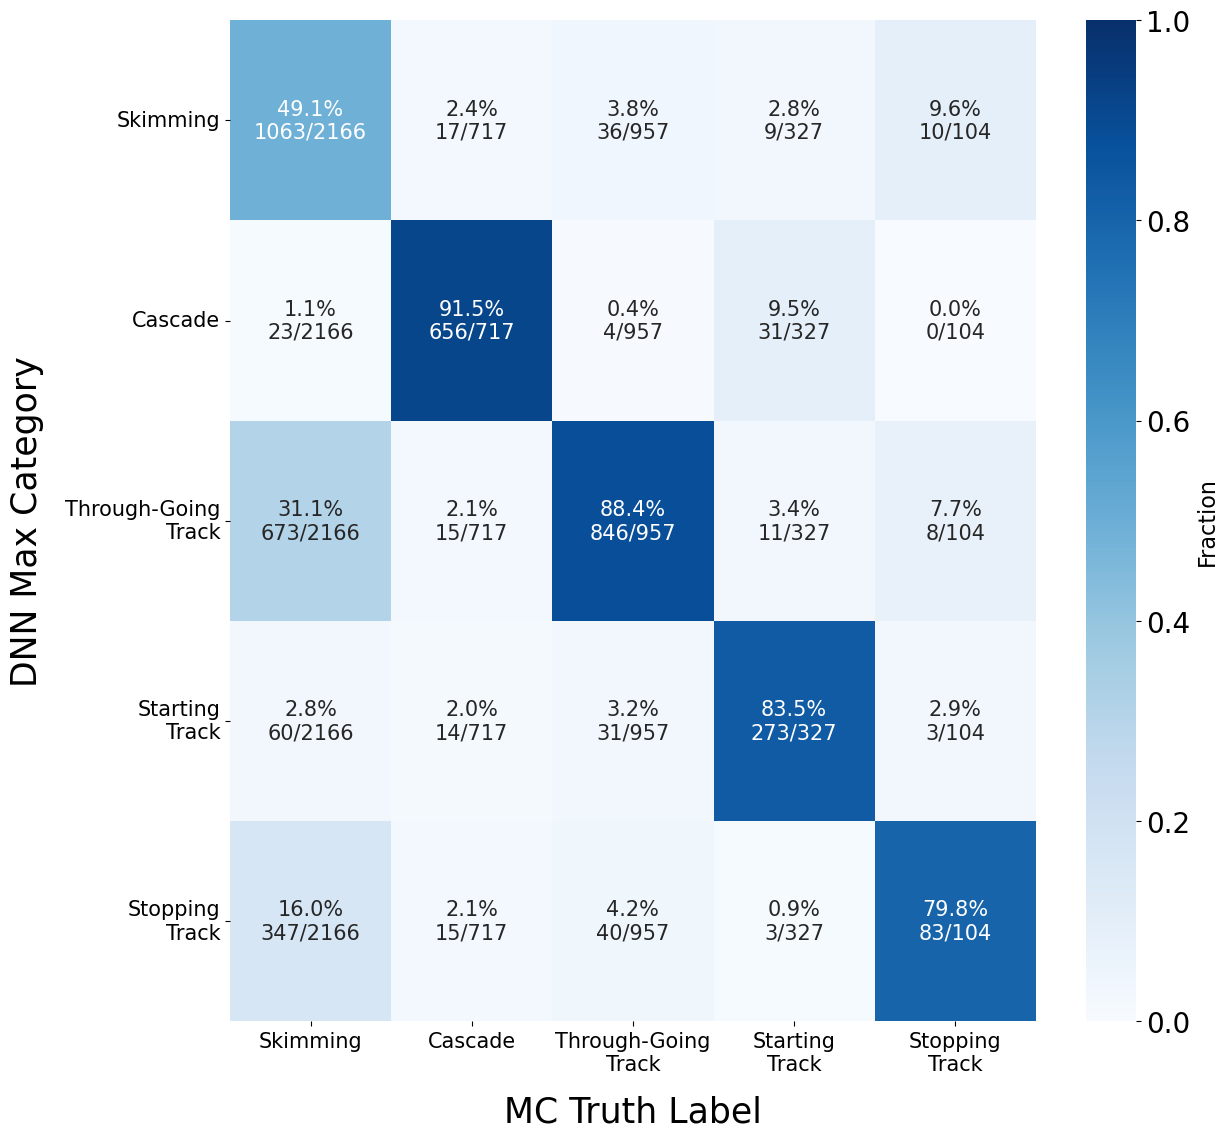

In [91]:
conf_norm = pd.crosstab(ntn_subjects['dnn_classification'], ntn_subjects['truth_classification'], rownames=['DNN Max Category'], colnames=['MC Truth Label'], margins=False,normalize='columns')
#confusion_matrix_user_ml_55_norm_20ret = confusion_matrix_user_ml_55_norm
conf = pd.crosstab(ntn_subjects['dnn_classification'], ntn_subjects['truth_classification'], rownames=['DNN Max Category'], colnames=['MC Truth Label'], margins=False)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(conf_norm, annot=GetUncertaintyLabels(conf), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
#plt.show()
plt.ylabel('DNN Max Category',fontsize=25,labelpad=15)
plt.xlabel('MC Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15")
#plt.savefig("ml_user_cm_cut.png")
#plt.title('DNN vs. MC, Qratio < {}'.format(thres))
plt.show()

### Extract columns

In [92]:
q_background = list(ntn_subjects['bg_charge'])
q_signal = list(ntn_subjects['signal_charge'])
q_total = list(ntn_subjects['qtot'])

### Apply new classification scheme

In [93]:
new_classification = []
for i, q in enumerate(q_background):
    if (q < q_signal[i]):
        new_classification.append(ntn_subjects['truth_classification'][i])
    else:
        new_classification.append(ntn_subjects['corsika_label'][i])

ntn_subjects.insert(0, 'new_classification', new_classification)
        

### DNN vs. MC, new classifcation scheme

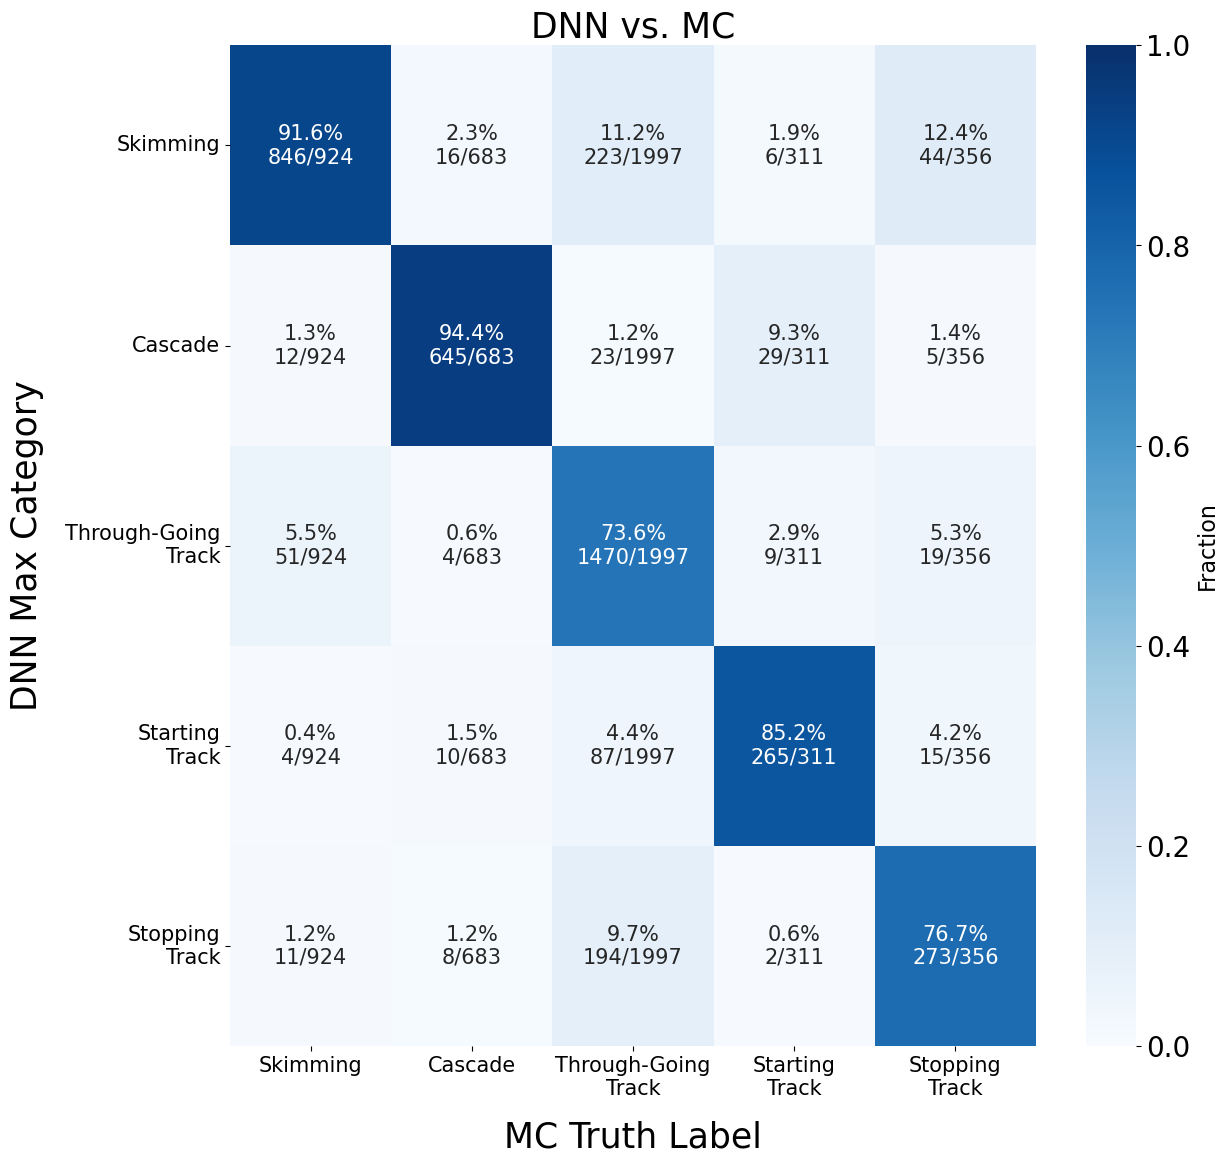

In [94]:
conf_norm = pd.crosstab(ntn_subjects['dnn_classification'], ntn_subjects['new_classification'], rownames=['DNN Max Category'], colnames=['MC Truth Label'], margins=False,normalize='columns')
#confusion_matrix_user_ml_55_norm_20ret = confusion_matrix_user_ml_55_norm
conf = pd.crosstab(ntn_subjects['dnn_classification'], ntn_subjects['new_classification'], rownames=['DNN Max Category'], colnames=['MC Truth Label'], margins=False)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(conf_norm, annot=GetUncertaintyLabels(conf), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
#plt.show()
plt.ylabel('DNN Max Category',fontsize=25,labelpad=15)
plt.xlabel('MC Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15")
#plt.savefig("ml_user_cm_cut.png")
plt.title('DNN vs. MC', fontsize=25)
plt.show()

### User vs. MC, new classification scheme

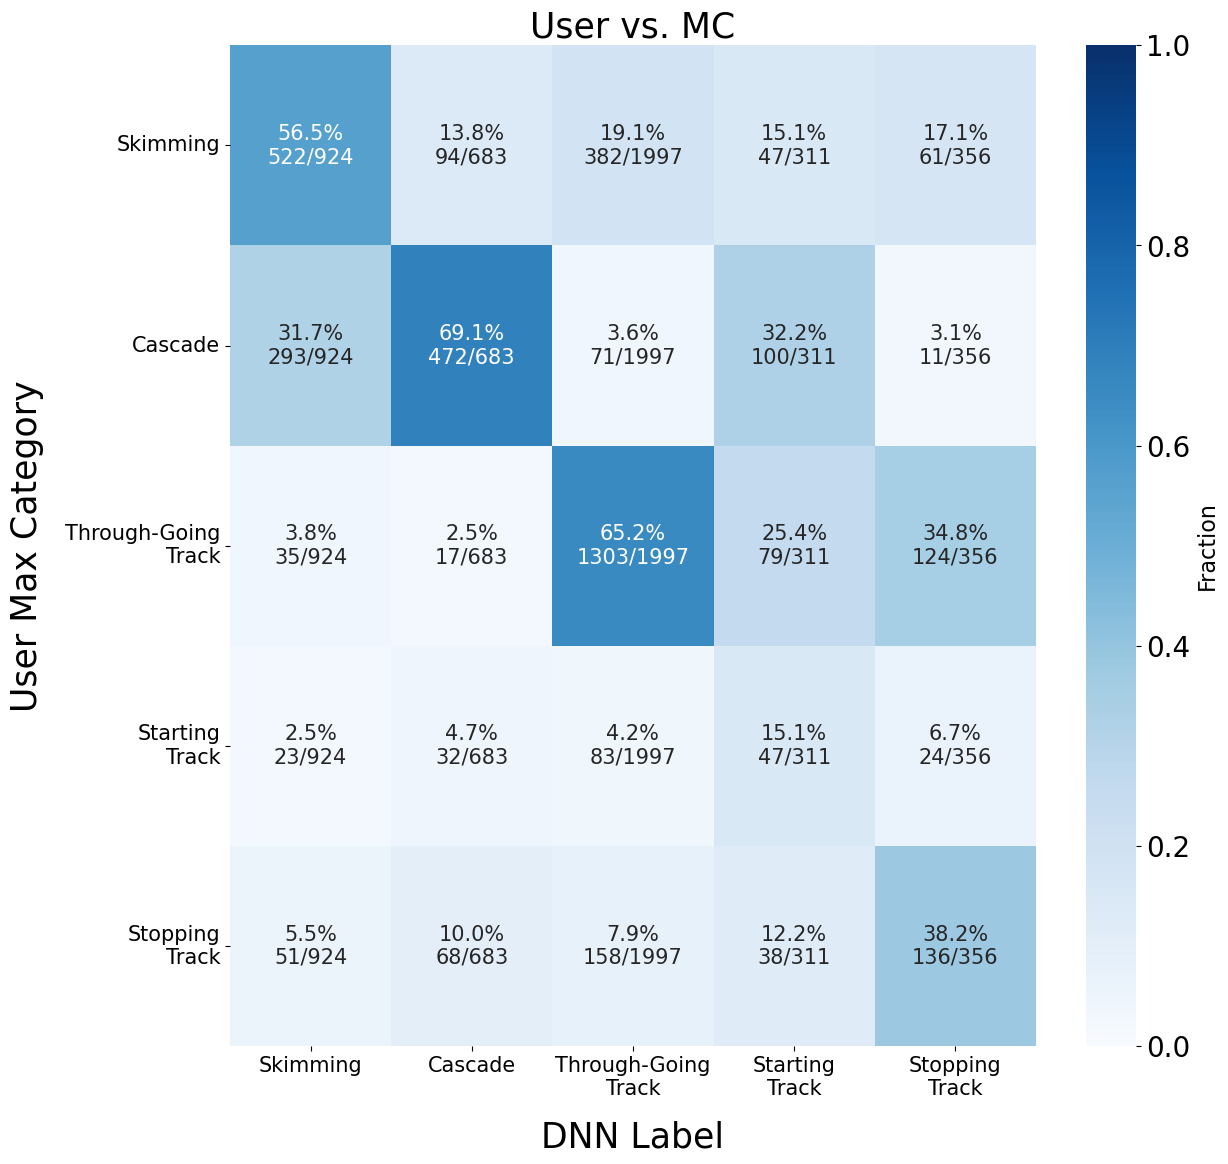

In [95]:
conf_norm = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['new_classification'], rownames=['User Max Category'], colnames=['DNN Label'], margins=False,normalize='columns')
#confusion_matrix_user_ml_55_norm_20ret = confusion_matrix_user_ml_55_norm
conf = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['new_classification'], rownames=['User Max Category'], colnames=['DNN Label'], margins=False)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(conf_norm, annot=GetUncertaintyLabels(conf), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
#plt.show()
plt.ylabel('User Max Category',fontsize=25,labelpad=15)
plt.xlabel('DNN Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15")
plt.title('User vs. MC', fontsize=25)
#plt.savefig("ml_user_cm_cut.png")
#plt.title('DNN vs. MC, Qratio < {}'.format(thres))
plt.show()

### Cut subjects at 55% user agreement

In [96]:
ntn_subjects = ntn_subjects[ntn_subjects['user agreement'] >= .55]

### DNN vs. MC, 55% cut, with new classification scheme

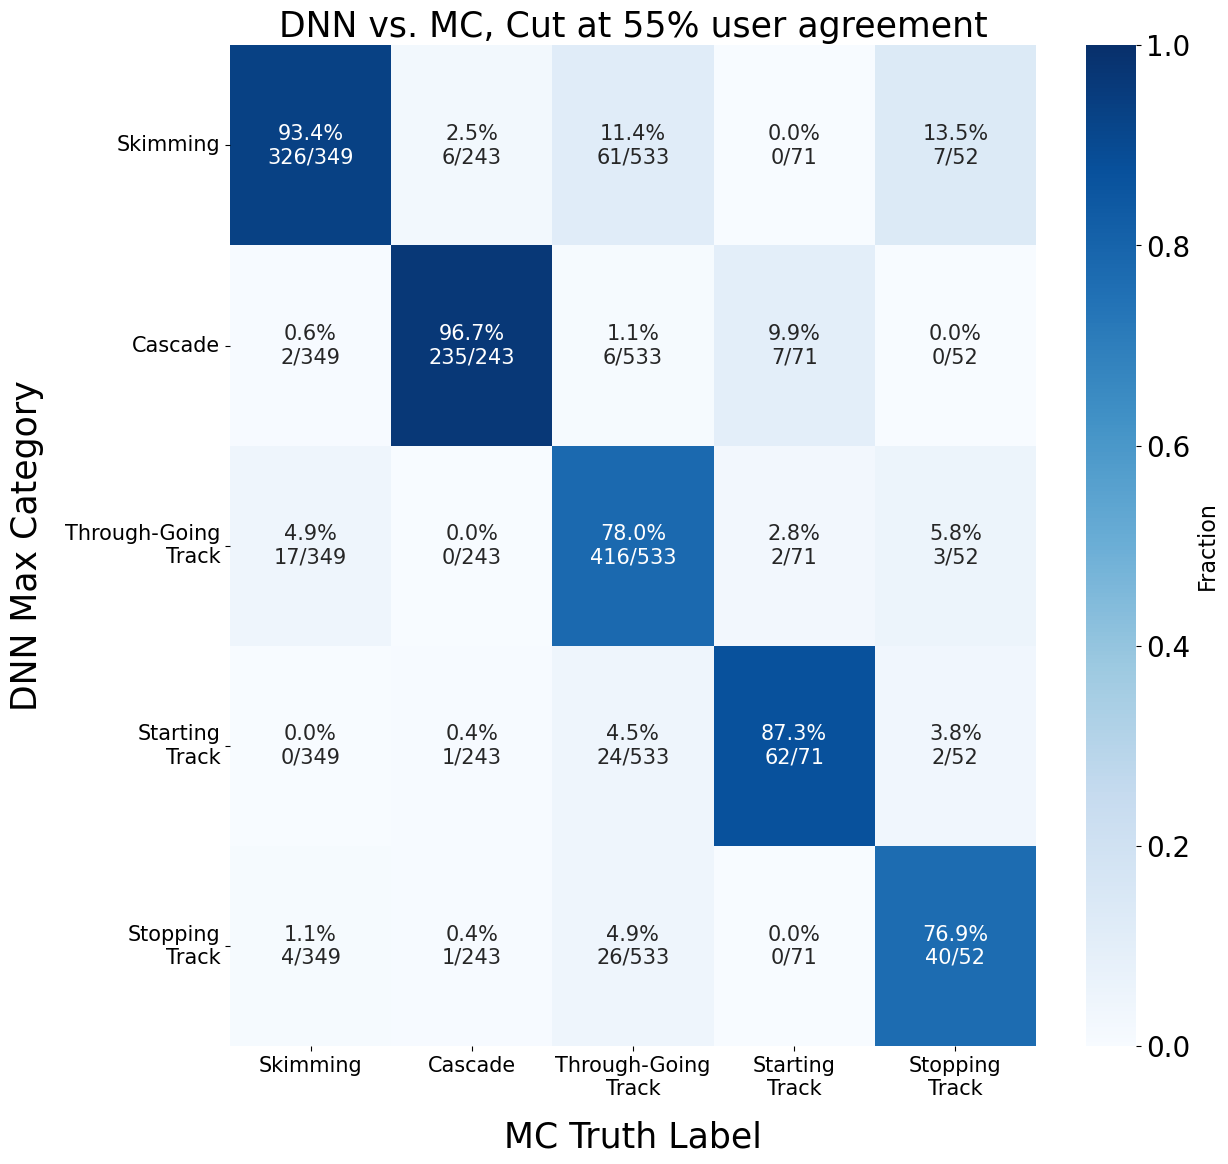

In [97]:
conf_norm = pd.crosstab(ntn_subjects['dnn_classification'], ntn_subjects['new_classification'], rownames=['DNN Max Category'], colnames=['MC Truth Label'], margins=False,normalize='columns')
#confusion_matrix_user_ml_55_norm_20ret = confusion_matrix_user_ml_55_norm
conf = pd.crosstab(ntn_subjects['dnn_classification'], ntn_subjects['new_classification'], rownames=['DNN Max Category'], colnames=['MC Truth Label'], margins=False)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(conf_norm, annot=GetUncertaintyLabels(conf), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
#plt.show()
plt.ylabel('DNN Max Category',fontsize=25,labelpad=15)
plt.xlabel('MC Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15")
#plt.savefig("ml_user_cm_cut.png")
plt.title('DNN vs. MC, Cut at 55% user agreement', fontsize=25)
plt.show()

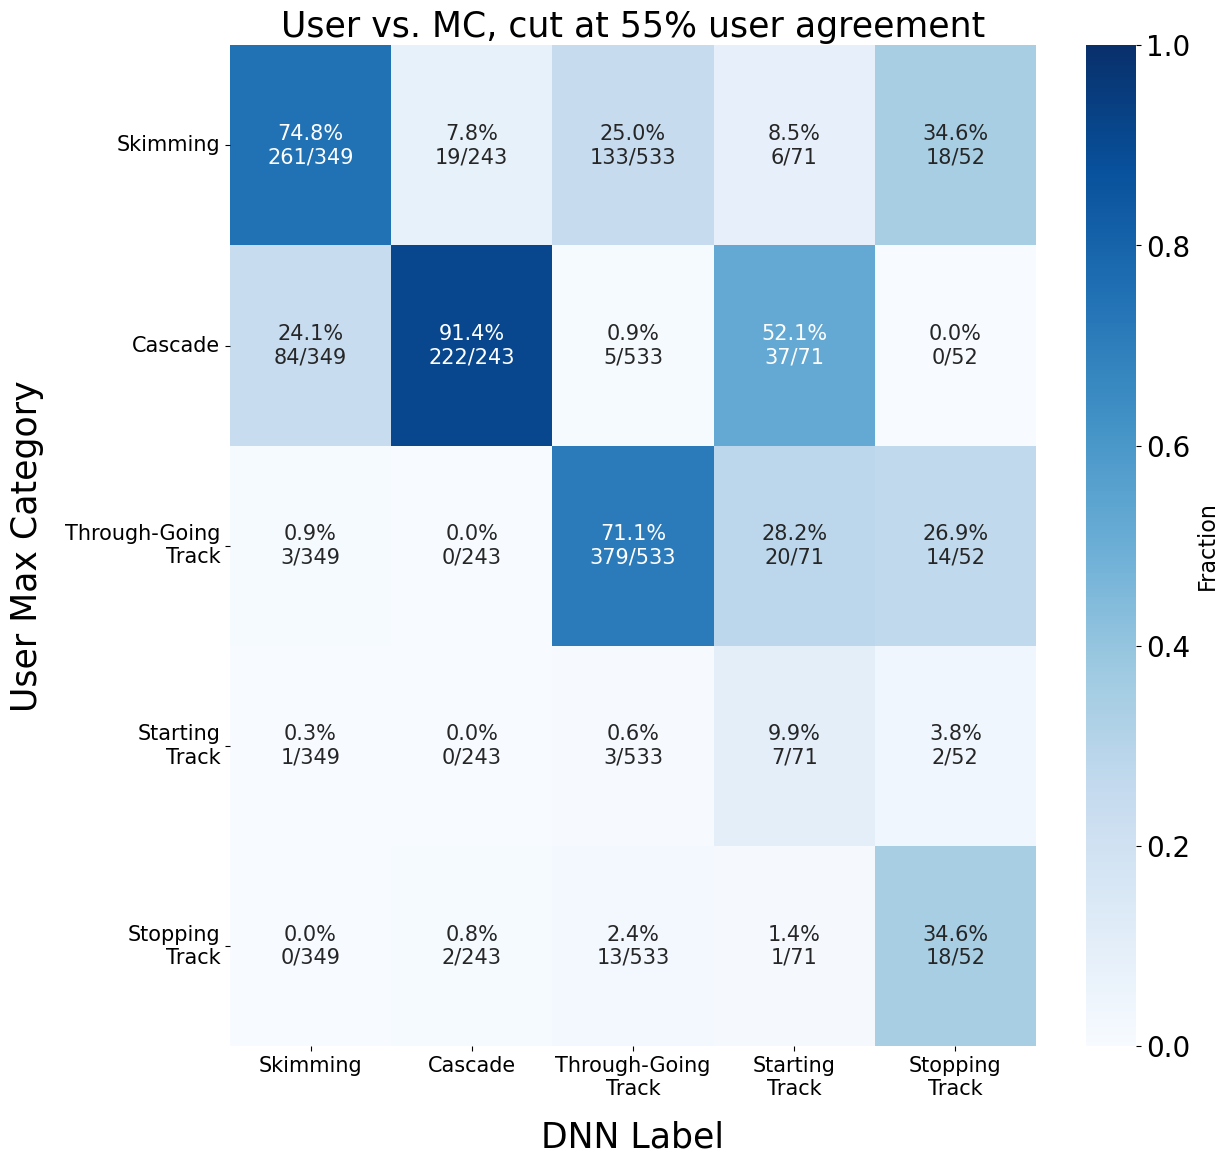

In [98]:
conf_norm = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['new_classification'], rownames=['User Max Category'], colnames=['DNN Label'], margins=False,normalize='columns')
#confusion_matrix_user_ml_55_norm_20ret = confusion_matrix_user_ml_55_norm
conf = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['new_classification'], rownames=['User Max Category'], colnames=['DNN Label'], margins=False)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(conf_norm, annot=GetUncertaintyLabels(conf), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
#plt.show()
plt.ylabel('User Max Category',fontsize=25,labelpad=15)
plt.xlabel('DNN Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15")
plt.title('User vs. MC, cut at 55% user agreement', fontsize=25)
#plt.savefig("ml_user_cm_cut.png")
#plt.title('DNN vs. MC, Qratio < {}'.format(thres))
plt.show()